`63070501061 S.RAKNA`

> 20 points, 1.5 hrs.

# Eigenfaces

- Using the `Eigenfaces.ipynb` program shown in class (*Lecture 6 folder*), 
- find the number of dimensions at which the variance preserved first hits the 50%, 60%, 70%, 80%, 90%, and 95% mark. 
- Then for each graph the macro average F-1 score for classification using `SVM`.

In [1]:
import logging
import tarfile
from time import time

import numpy as np
import pylab as pl
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC


In [2]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz


In [3]:
% % time
tfile = tarfile.open("lfw-funneled.tgz", "r:gz")
tfile.extractall(".")


UsageError: Line magic function `%` not found.


In [4]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


In [6]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape # type: ignore
np.random.seed(42)


In [7]:
n_samples, h, w


(1288, 50, 37)

In [8]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data # type: ignore
n_features = X.shape[1]


In [9]:
# the label to predict is the id of the person
y = lfw_people.target # type: ignore
target_names = lfw_people.target_names # type: ignore
n_classes = target_names.shape[0]
print("target y = \n", y)  # target 0-6 for 7 people
print("target names = \n", target_names)


target y = 
 [5 6 3 ... 5 3 5]
target names = 
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [10]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


#### Split into a training and testing set

In [11]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)


#### Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset)

In [12]:
n_components = 150


In [13]:
print("Extracting the top %d eigenfaces from %d faces" %
      (n_components, X_train.shape[0]))
t0 = time()
# create the PCA
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 5.733s


In [14]:
eigenfaces = pca.components_.reshape((n_components, h, w))


In [15]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
# transform the data into the principle component representation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


#### Train a SVM classification model

In [16]:
print("Fitting the classifier to the training set")
# try many hyperparameter combinations of C, gamma
t0 = time()
param_grids = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
# create the classifier
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
# fit the data
clf = clf.fit(X_train_pca, y_train)

print('done in %0.3fs' % (time() - t0))
print('Best estimator found in grid search:')
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 13.071s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


#### Quantitative evaluation of the model quality on the test set

In [17]:
print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs' % (time() - t0))


Predicting the people names on the testing set
done in 0.037s


In [18]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.85      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.91      0.83      0.87        36

         accuracy                           0.86       322
        macro avg       0.91      0.74      0.80       322
     weighted avg       0.87      0.86      0.86       322

[[  7   1   0   5   0   0   0]
 [  1  53   0   6   0   0   0]
 [  0   3  17   6   0   0   1]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   1   1   8   1]
 [  0   1   1   4   0   0  30]]


#### Qualitative evaluation of the predictions using matplotlib

In [19]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


#### Plot the result of the prediction on a portion of the test set

In [20]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


In [21]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]


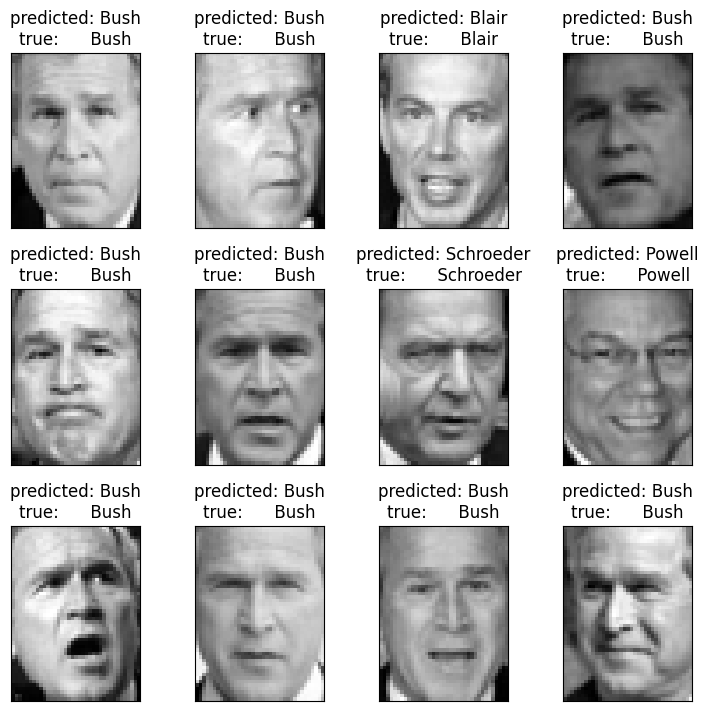

In [22]:
plot_gallery(X_test, prediction_titles, h, w)


#### Plot the gallery of the most significative eigenfaces

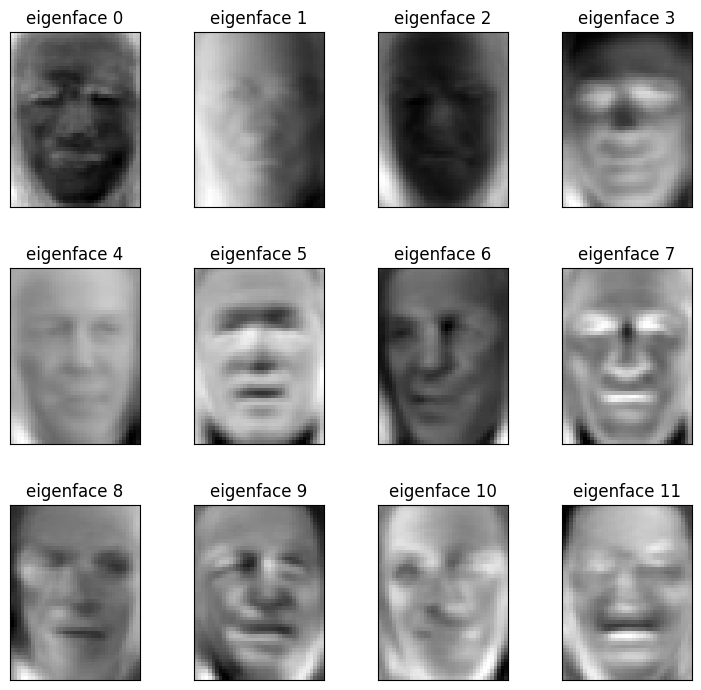

In [23]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


#### Cumulative explained variance

In [24]:
# sum up lambda's
accum = pca.explained_variance_ratio_
sum = 0.0
for i in range(pca.explained_variance_ratio_.shape[0]):
    accum[i] = sum + pca.explained_variance_ratio_[i]
    sum = accum[i]
print(accum)


[0.20860413 0.3490733  0.41632983 0.4727436  0.5217241  0.5491534
 0.5731013  0.59426427 0.61328214 0.6313282  0.6470118  0.6620804
 0.6739227  0.6842342  0.6945197  0.7039568  0.7125968  0.72077495
 0.7287854  0.7359891  0.74272054 0.7489928  0.75522286 0.76067424
 0.76583904 0.7709462  0.7759149  0.78065354 0.78498226 0.7891378
 0.79302907 0.79688823 0.80047    0.8039309  0.80733955 0.81062806
 0.8138057  0.81682587 0.8197488  0.8226188  0.82538575 0.8280724
 0.8306842  0.83328867 0.8357472  0.838184   0.8405926  0.8428328
 0.8450151  0.847154   0.84928894 0.8513661  0.85343206 0.85546213
 0.85744953 0.8593384  0.86121064 0.8630647  0.8648656  0.86664826
 0.86835873 0.87002003 0.8716444  0.8732379  0.8748075  0.87633157
 0.8778183  0.87929654 0.8807599  0.88220996 0.8836172  0.88501096
 0.88638467 0.8877184  0.8890303  0.8903253  0.89159244 0.89282125
 0.89403594 0.8952467  0.89644074 0.89762974 0.8987898  0.8999436
 0.9010823  0.9022002  0.9032871  0.9043666  0.9054213  0.90645313
 

In [25]:
# the original dimensionality is over 1800
# n_components = 150

# change to n_components for 50%, 60%, 70%, 80%, 90%, 95%
explained_variances = []

for n_components in [50, 60, 70, 80, 90, 95]:
    print("Extracting the top %d eigenfaces from %d faces" %
          (n_components, X_train.shape[0]))
    t0 = time()
    # create the PCA
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    # principle components of the face data
    # reshape the data so they can look like pictures
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    # transform the data into the principle component representation
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))

    print("Fitting the classifier to the training set")
    t0 = time()
    # use the hyperparameters found earlier here
    clf = SVC(C=1000.0, class_weight='balanced', gamma=0.005)
    '''
    param_grids = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
    }
    # create the classifier with all pairings of "C", and "Gamma" hyperparameters
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
    '''
    # fit the data
    clf = clf.fit(X_train_pca, y_train)
    print('done in %0.3fs' % (time() - t0))

    # Calculate the explained variance ratio
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

    # print('Best estimator fount in grid search:')
    # print(clf.best_estimator_)

    print("Predicting the people names on the testing set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print('done in %0.3fs' % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Extracting the top 50 eigenfaces from 966 faces
done in 6.932s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.207s
Fitting the classifier to the training set
done in 0.049s
Predicting the people names on the testing set
done in 0.025s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.75      0.56      0.64        27
    George W Bush       0.85      0.87      0.86       146
Gerhard Schroeder       0.67      0.72      0.69        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.80      0.67      0.73        36

         accuracy                           0.79       322
        macro avg       0.73      0.70      0.71       322
     weighted avg       0.79      0.79      0.79       322

[[  9   1   2   1   0   0   0]
 [  0  53   0   7   0   0   0]
 [  2   2  15   7   1   0 

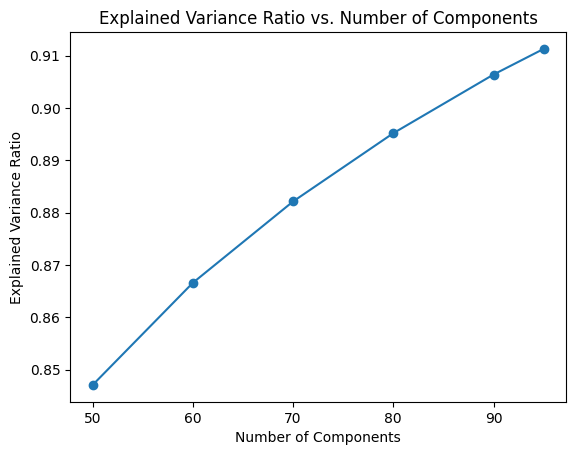

In [26]:
# Plot the explained variance ratio
import matplotlib.pyplot as plt

plt.plot([50, 60, 70, 80, 90, 95], explained_variances, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()
